In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import pandas as pd
import missingno as msno
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit, LeaveOneOut, GridSearchCV
from sklearn import linear_model
from sklearn.tree import _tree, export_graphviz, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.externals import joblib
import graphviz
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns=100
pd.options.display.max_rows=100

# Creation Of Model

In [2]:
df = pd.read_csv('cleaned_df4.csv')
df = df.drop('gallons per bedroom per month', axis=1)
cols = df.columns.tolist()
cols = [col for col in cols if not col.endswith('.1')]
df = df[cols]
df = df.rename(columns={'match building name': 'building'})
d = df.copy()

#### Beginning of outlier detection

df = df[['building', 'month', 'year', 'target']]
month_mapping = {'april': 4,
 'august': 8,
 'december': 12,
 'february': 2,
 'january': 1,
 'july': 7,
 'june': 6,
 'march': 3,
 'may': 5,
 'november': 11,
 'october': 10,
 'september': 9}

df['month_num'] = df['month'].map(month_mapping)

df['date'] = ['{}/1/{}'.format(month, year) for month, year in df[['month_num', 'year']].values]
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

bldg_dict = {}

yes_count, no_count = 0, 0

stddev_n = 3

months = []

total_outliers = []

master = pd.DataFrame()

for building, frame in df.groupby('building'):
    frame = frame.set_index('date', inplace=False).sort_index()
    med = np.median(frame['target'])
    std = np.std(frame['target'])

    lower, upper = -stddev_n*std, stddev_n*std

    lower_cons, upper_cons = (med + lower, med + upper)

    lower_cons = lower_cons if lower_cons >= 0 else 0

    bldg_dict[building] = {'med': med, 'std': std, 'lower_cons': lower_cons, 'upper_cons': upper_cons}
    cons = frame['target'].values.tolist()

   
    if any(obs > upper_cons or obs < lower_cons for obs in cons):
        yes_count += 1
        filt = frame.loc[~(frame['target'] > upper_cons) | (frame['target'] < lower_cons)]

        filt['outliers_removed'] = True
        master = pd.concat([master, filt])
        # print('Outliers detected for {}'.format(building))

    else:
        no_count += 1
        frame = frame.assign(outliers_removed = False)
        # print('No outliers detected for {}'.format(building))
        master = pd.concat([master, frame]) 
print('Number of buildings with outliers:  {}'.format(yes_count))
print('Number of buildings without outliers:  {}'.format(no_count))

/Users/Greg/anaconda/envs/main/lib/python3.4/site-packages/ipykernel/__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of buildings with outliers:  47
Number of buildings without outliers:  30


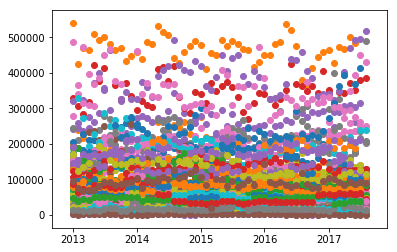

In [3]:
for building, group in master.groupby('building'):
    plt.scatter(x=group.index, y=group['target'])

In [4]:
d_ = pd.merge(d, master, left_on=['building', 'month', 'year', 'target'], right_on=['building', 'month', 'year', 'target'], how='right')

In [5]:
d_.shape

(4205, 42)

# Create Feature Matrix

In [11]:
df = d_.copy()

In [12]:
cols = df.columns.tolist()
cols = [col for col in cols if df[col].dtypes == 'object']
for col in cols:  df[col] = df[col].str.lower()

In [15]:
df.head()

,building,month,year,single family?,single family building type,low-income housing,predominant resident type,type of construction,is there a basement?,is basement finished & heated?,environmental certification,if environmental certification: type,heating fuel,heating system,hot water system fuel,hot water system,cooling system,common laundry facilities,"if common laundry, dryer fuel",total # bedrooms in building,target,gross bldg sq ft,if multi-family sum of apt sq ft,basement sq ft,# stories,"if multi-family, # units",# elevators,# of days in month,0 bedrooms - days vacant,1 bedrooms days vacant,2 bedrooms days vacant,3 bedrooms days vacant,4 bedrooms days vacant,# of 0 bedrooms * days in month,# of 1 bedrooms * days in month,# of 2 bedrooms * days in month,# of 3 bedrooms * days in month,# of 4 bedrooms * days in month,# of 5 bedrooms * days in month,bldg_age,month_num,outliers_removed
0,1822 park,august,2017,no,0,yes,mixed/none,masonry,yes,yes,no,no,natural gas,boiler (steam),natural gas,other,window ac,yes,natural gas,18,30862.9998,18000.0,9772,4500,4.0,18,0,31,0,0,0,0,0,0,558,0,0,0,0,101,8,True
1,alliance addition-730 17th street,august,2017,no,0,yes,mixed/none,wood or steel frame,yes,yes,yes,"leed, platinum",electricity,heat pump (air-source),electricity,stand-alone storage water heater,ducted central ac (outdoor condenser),yes,natural gas,61,78751.0000,33124.0,20790,7126,3.0,51,1,31,261,0,0,0,0,1829,62,0,0,0,0,117,8,False
2,archdale,august,2017,no,0,yes,mixed/none,masonry,yes,yes,no,no,natural gas,boiler (steam),natural gas,stand-alone storage water heater,window ac,yes,natural gas,30,117300.0000,19760.0,12178,4940,3.0,30,0,31,48,33,0,0,0,806,124,0,0,0,0,98,8,True
3,st. barnabas,august,2017,no,0,yes,mixed/none,masonry,yes,yes,no,no,natural gas,boiler (hot water),natural gas,indirect hot water tank off boiler (heat & dhw),ducted central ac (outdoor condenser),yes,natural gas,52,88704.6004,32467.0,17316,6839,5.0,52,1,31,277,0,0,0,0,1612,0,0,0,0,0,12,8,True
4,buri manor,august,2017,no,0,yes,mixed/none,wood or steel frame,no,no,no,no,electricity,electric baseboard,electricity,stand-alone storage water heater,window ac,yes,natural gas,38,63680.7990,16464.0,9970,0,3.0,38,0,31,48,0,0,0,0,1178,0,0,0,0,0,31,8,True


In [16]:
# Need to split up the dataframes into categoricals and numericals
cats = df.loc[:, 'month':'if common laundry, dryer fuel']
cats = cats.drop('year', axis=1)
nums = df.loc[:, 'total # bedrooms  in building':'bldg_age']
nums = nums.drop('target', axis=1)
targets = df['target'].copy()
cats.head()

,month,single family?,single family building type,low-income housing,predominant resident type,type of construction,is there a basement?,is basement finished & heated?,environmental certification,if environmental certification: type,heating fuel,heating system,hot water system fuel,hot water system,cooling system,common laundry facilities,"if common laundry, dryer fuel"
0,august,no,0,yes,mixed/none,masonry,yes,yes,no,no,natural gas,boiler (steam),natural gas,other,window ac,yes,natural gas
1,august,no,0,yes,mixed/none,wood or steel frame,yes,yes,yes,"leed, platinum",electricity,heat pump (air-source),electricity,stand-alone storage water heater,ducted central ac (outdoor condenser),yes,natural gas
2,august,no,0,yes,mixed/none,masonry,yes,yes,no,no,natural gas,boiler (steam),natural gas,stand-alone storage water heater,window ac,yes,natural gas
3,august,no,0,yes,mixed/none,masonry,yes,yes,no,no,natural gas,boiler (hot water),natural gas,indirect hot water tank off boiler (heat & dhw),ducted central ac (outdoor condenser),yes,natural gas
4,august,no,0,yes,mixed/none,wood or steel frame,no,no,no,no,electricity,electric baseboard,electricity,stand-alone storage water heater,window ac,yes,natural gas


In [20]:
nums.columns.tolist()  # Numerical Variables Kept For Modeling
cats.columns.tolist()  # Categorical variables to keep for modeling
cats_ = pd.get_dummies(cats)  # Encode the categorical variables

# Concatenate the targets, the buildings, the categorical variables, and the numerical variables, then create a holdout training / validation split
bldgs = df['building']
X_df = pd.concat([ bldgs, targets, cats_, nums], axis=1)
valid_set = X_df.sample(frac=0.2)
X_df = X_df.loc[~X_df.index.isin(valid_set.index)].copy()

print('Size of the dataset:  {}'.format(X_df.shape))
print('Size of the validation set:  {}'.format(valid_set.shape))
print('Size of the new training set is:  {}'.format(X_df.shape))
print('Describe the training dataset...')
print(X_df['target'].describe())

Size of the dataset:  (3364, 85)
Size of the validation set:  (841, 85)
Dropping the validation samples...
Size of the new training set is:  (3364, 85)
Describe the training dataset...
count      3364.000000
mean      98305.166893
std      102565.203001
min           0.000000
25%       21066.000000
50%       69099.949400
75%      138104.498625
max      537901.005000
Name: target, dtype: float64


In [21]:
X_df.head()

,building,target,month_april,month_august,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september,single family?_no,single family?_yes,single family building type_0,single family building type_detached,single family building type_shared wall,low-income housing_no,low-income housing_yes,predominant resident type_elderly,predominant resident type_mixed/none,type of construction_masonry,type of construction_wood or steel frame,is there a basement?_no,is there a basement?_yes,is basement finished & heated?_no,is basement finished & heated?_yes,environmental certification_no,environmental certification_yes,"if environmental certification: type_leed, gold","if environmental certification: type_leed, platinum",if environmental certification: type_no,if environmental certification: type_other (type in),heating fuel_electricity,heating fuel_natural gas,heating fuel_steam,heating system_boiler (high efficiency condensing),heating system_boiler (hot water),heating system_boiler (steam),heating system_electric baseboard,heating system_furnace,heating system_furnace (high efficiency condensing),heating system_heat pump (air-source),heating system_heat pump (ground-source),heating system_ptac units,hot water system fuel_electricity,hot water system fuel_natural gas,hot water system_indirect hot water tank off boiler (heat & dhw),hot water system_indirect hot water tank off dedicated boiler,hot water system_no,hot water system_other,hot water system_stand-alone storage water heater,cooling system_air-cooled chiller,cooling system_ducted central ac (outdoor condenser),cooling system_packaged rooftop cooling system,cooling system_ptac unit,cooling system_room ac in sleeve (through wall ),cooling system_window ac,common laundry facilities_no,common laundry facilities_yes,"if common laundry, dryer fuel_0","if common laundry, dryer fuel_electricity","if common laundry, dryer fuel_natural gas",total # bedrooms in building,gross bldg sq ft,if multi-family sum of apt sq ft,basement sq ft,# stories,"if multi-family, # units",# elevators,# of days in month,0 bedrooms - days vacant,1 bedrooms days vacant,2 bedrooms days vacant,3 bedrooms days vacant,4 bedrooms days vacant,# of 0 bedrooms * days in month,# of 1 bedrooms * days in month,# of 2 bedrooms * days in month,# of 3 bedrooms * days in month,# of 4 bedrooms * days in month,# of 5 bedrooms * days in month,bldg_age
0,1822 park,30862.9998,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,18,18000.0,9772,4500,4.0,18,0,31,0,0,0,0,0,0,558,0,0,0,0,101
2,archdale,117300.0000,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,30,19760.0,12178,4940,3.0,30,0,31,48,33,0,0,0,806,124,0,0,0,0,98
3,st. barnabas,88704.6004,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,52,32467.0,17316,6839,5.0,52,1,31,277,0,0,0,0,1612,0,0,0,0,0,12
5,chicago ave-1500,113390.0012,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,28,21328.0,15993,7109,3.0,24,0,31,0,0,0,0,0,0,682,0,62,0,0,101
7,chicago ave-1508,77386.8004,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,26,17532.0,13104,5844,3.0,12,0,31,0,0,0,0,0,0,0,310,62,0,0,101


/Users/Greg/anaconda/envs/main/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


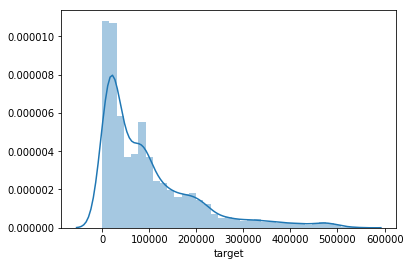

In [22]:
sns.distplot(X_df['target'])

In [23]:
def create_dsets(df):
    target = df['target'].values
    bldgs = df['building'].tolist()
    X = df.drop(['target', 'building'], axis=1)
    features = X.columns.tolist()
    X = X.values
    return X, target, bldgs, features

In [38]:
def makeplot(estimator, X, y, X_valid, y_valid, title):
    predicted = estimator.predict(X)
    pred_valid = estimator.predict(X_valid)
    
    score = "Training R2 Score:  {}".format(estimator.score(X, y))
    score2 = "Validation R2 Score:  {}".format(estimator.score(X_valid, y_valid))

    mse = "Training MSE:  {}".format(mean_squared_error(y, estimator.predict(X)))
    mse2 = "Validation MSE:  {}".format(mean_squared_error(y_valid, estimator.predict(X_valid)))

    mae = 'Training Median Absolute Error is:  {}'.format(median_absolute_error(y, estimator.predict(X)))
    mae2 = 'Validation Median Absolute Error is:  {}'.format(median_absolute_error(y_valid, estimator.predict(X_valid)))

    plt.figure(figsize=(15,9))
    plt.title(title)
    
    plt.scatter(y, y)
    plt.scatter(y, predicted, edgecolors='red', facecolors='none')
    plt.scatter(y_valid, pred_valid, edgecolors='green', facecolors='green')
    
    plt.annotate(score, xy=(0.05, .86), xycoords='axes fraction')
    plt.annotate(score2, xy=(.05, .84), xycoords='axes fraction')
    
    plt.annotate(mse, xy=(.05, .82), xycoords='axes fraction')
    plt.annotate(mse2, xy=(.05, .80), xycoords='axes fraction')


    plt.annotate(mae, xy=(.05, .78), xycoords='axes fraction')
    plt.annotate(mae2, xy=(.05, .76), xycoords='axes fraction')


    plt.annotate('Blue = Actual', xy=(.05, .90), xycoords='axes fraction')
    plt.annotate('Red = Predicted', xy=(.05, .88), xycoords='axes fraction')
    plt.annotate('Green = Validation', xy=(0.05, 0.92), xycoords='axes fraction')
    
    plt.xlabel('Actual Water Consumption per Building')
    plt.ylabel('Predicted Water Consumption per Building')
    plt.show()

In [39]:
def train_model(X, y, estimator, params):
    grid = GridSearchCV(estimator = estimator, cv=10, param_grid=params, n_jobs=-1)
    grid.fit(X, y)
    return grid

In [73]:
def plot_variables(features, data, X):
    """Describes the number of features used in model training and their importance
    
    :param features = A list of feature names
    :param data = The coefficients of feature_importances associated with the best model
    :param X = The array used for model training
    """
    
    print('The model was trained with {} features.  Of those {} features contribute to the outcome.'.format(X.shape[1], len(data)))
    f = pd.DataFrame(index=features, data=data, columns=['Feature Importance'])
    f.loc[f_['Strength'] != 0].plot(kind='barh', figsize=(10,10))
    return None
    

In [74]:
# Create the matrices for training a model, the target values, list of building names, and the featurenames for both the training data, and the validation data
X, y, bldgs, features = create_dsets(X_df)
X_valid, y_valid, bldgs_valid, _ = create_dsets(valid_set)

In [75]:
features

['month_april',
 'month_august',
 'month_december',
 'month_february',
 'month_january',
 'month_july',
 'month_june',
 'month_march',
 'month_may',
 'month_november',
 'month_october',
 'month_september',
 'single family?_no',
 'single family?_yes',
 'single family building type_0',
 'single family building type_detached ',
 'single family building type_shared wall ',
 'low-income housing_no',
 'low-income housing_yes',
 'predominant resident type_elderly',
 'predominant resident type_mixed/none',
 'type of construction_masonry',
 'type of construction_wood or steel frame',
 'is there a basement?_no',
 'is there a basement?_yes',
 'is basement finished & heated?_no',
 'is basement finished & heated?_yes',
 'environmental certification_no',
 'environmental certification_yes',
 'if environmental certification: type_leed, gold',
 'if environmental certification: type_leed, platinum',
 'if environmental certification: type_no',
 'if environmental certification: type_other (type in)',
 'he

## Benchmark Linear Regression

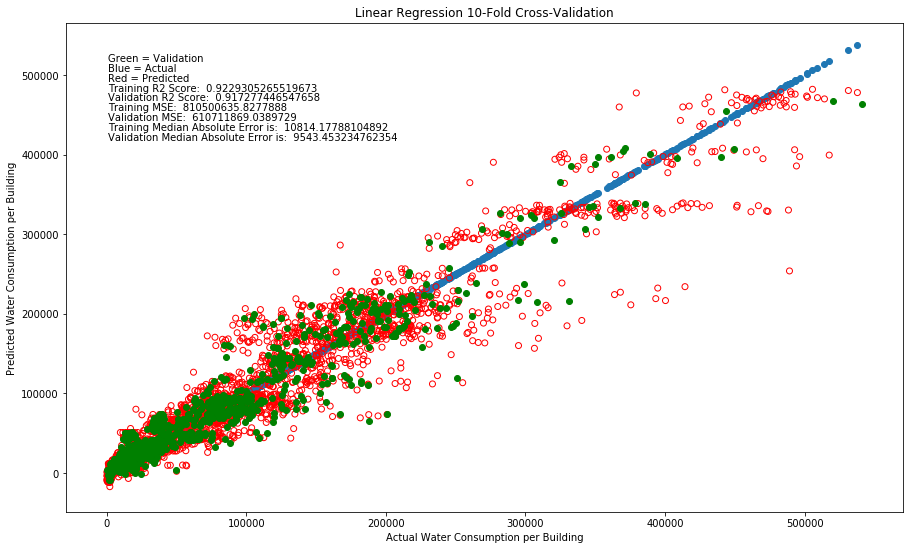

The model was trained with 83 features.  Of those 83 features contribute to the outcome.


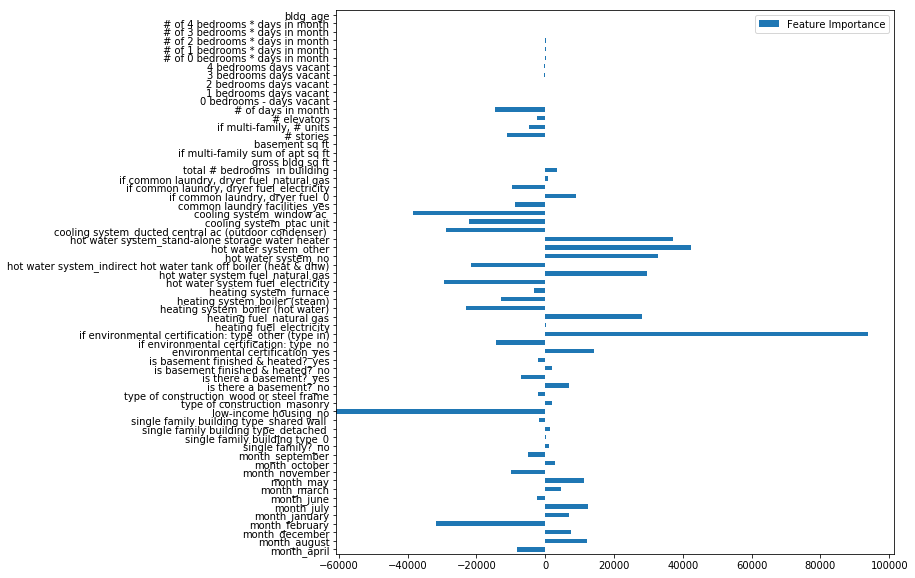

In [76]:
lr_ = linear_model.LinearRegression()
lr = train_model(X=X, y=y, estimator=lr_, params=[{'normalize': [True, False]}])
makeplot(estimator=lr, X=X, y=y, X_valid=X_valid, y_valid=y_valid, title='Linear Regression 10-Fold Cross-Validation')
plot_variables(features=features, data=lr.best_estimator_.coef_, X=X)

## Decision Tree Regressor

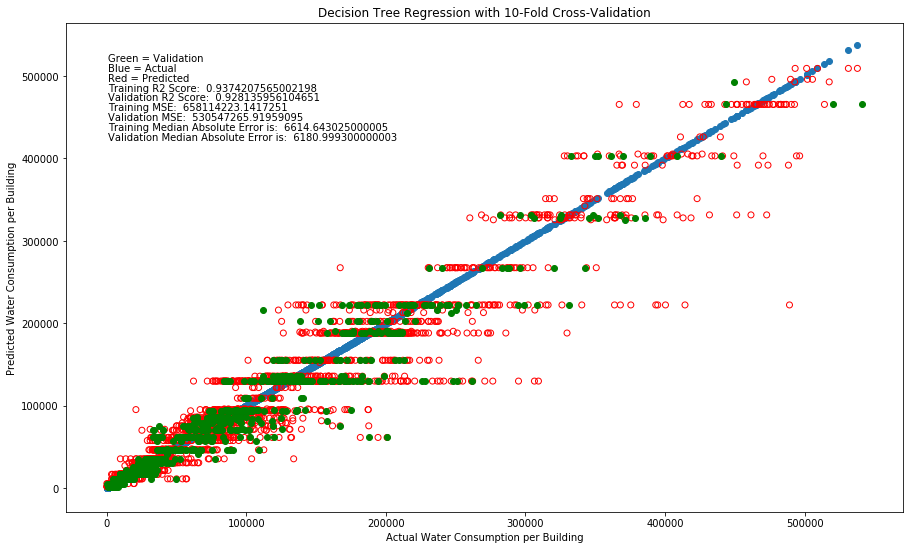

The model was trained with 83 features.  Of those 83 features contribute to the outcome.


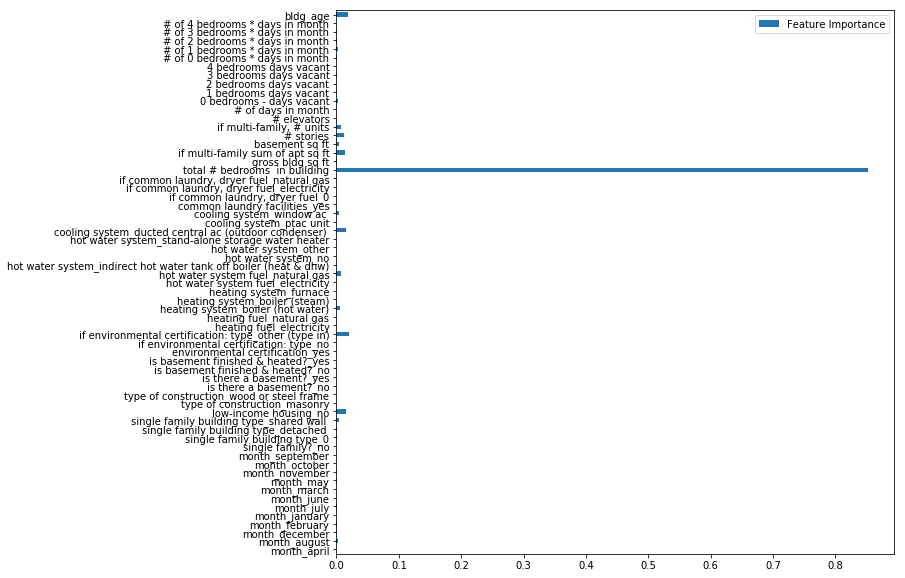

In [85]:
clf_ = DecisionTreeRegressor(criterion='mae')
clf1 = train_model(X=X, y=y, estimator=clf_, params=[{'max_depth': [6], 'min_samples_split': [4, 6]}])
makeplot(estimator=clf1, X=X, y=y, X_valid=X_valid, y_valid=y_valid, title='Decision Tree Regression with 10-Fold Cross-Validation')
plot_variables(features=features, data=clf1.best_estimator_.feature_importances_, X=X)

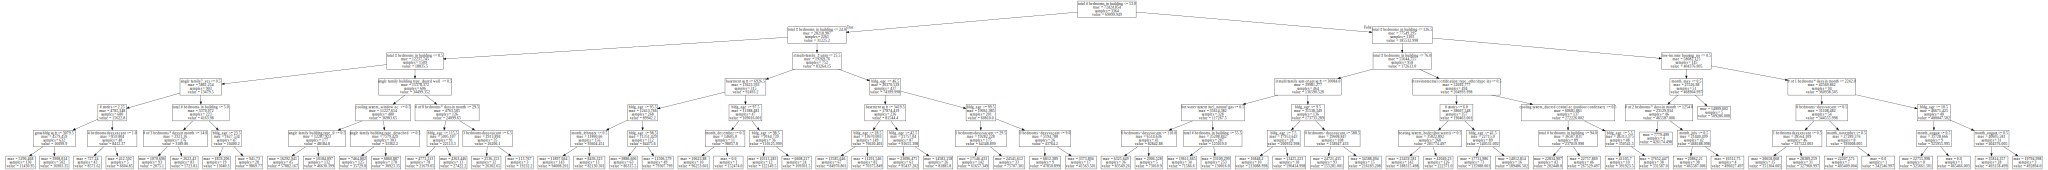

In [86]:
clfplot=export_graphviz(clf1.best_estimator_, out_file='my_tree.dot', feature_names=features)
with open('my_tree.dot') as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

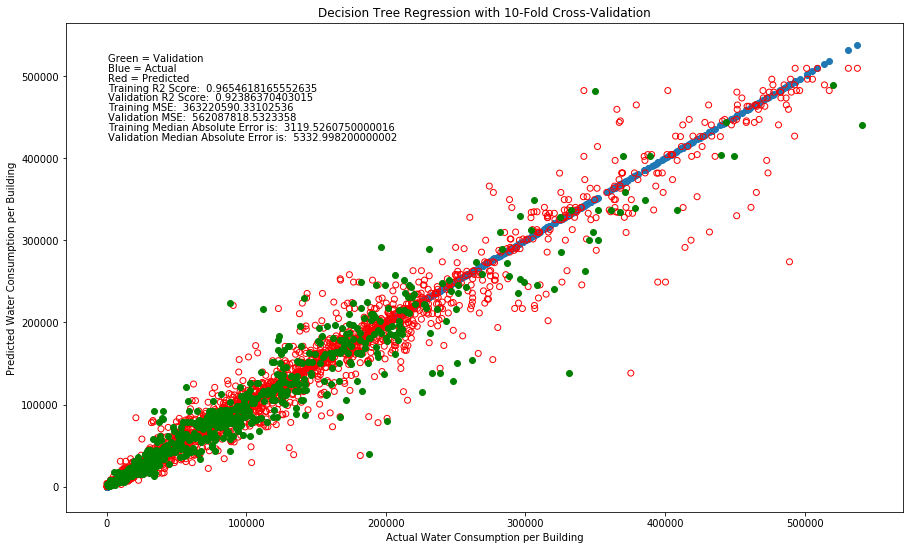

The model was trained with 83 features.  Of those 83 features contribute to the outcome.


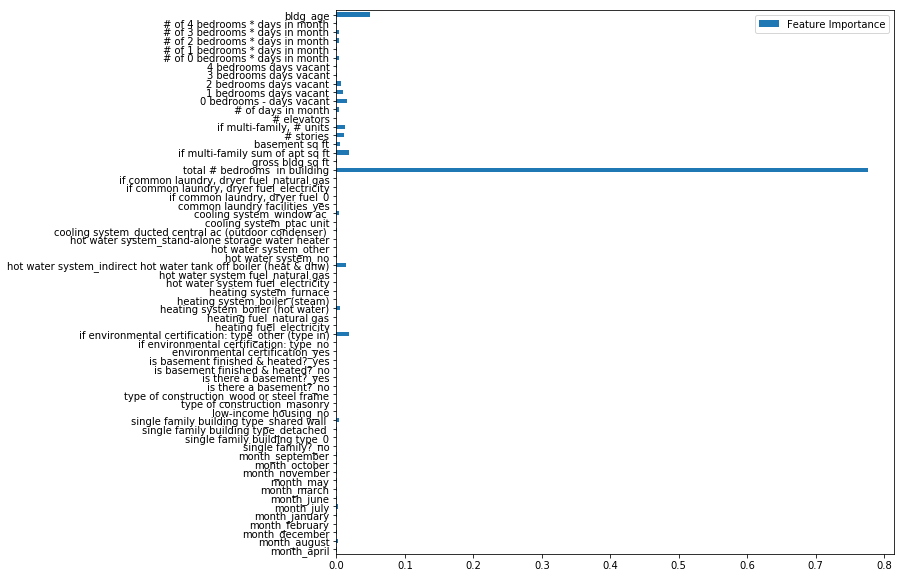

In [88]:
clf_ = DecisionTreeRegressor(criterion='mae')
clf2 = train_model(X=X, y=y, estimator=clf_, params=[{'max_depth': [None], 'min_samples_split': [4, 6], 'min_samples_leaf':[4]}])
makeplot(estimator=clf2, X=X, y=y, X_valid=X_valid, y_valid=y_valid, title='Decision Tree Regression with 10-Fold Cross-Validation')
plot_variables(features=features, data=clf2.best_estimator_.feature_importances_, X=X)

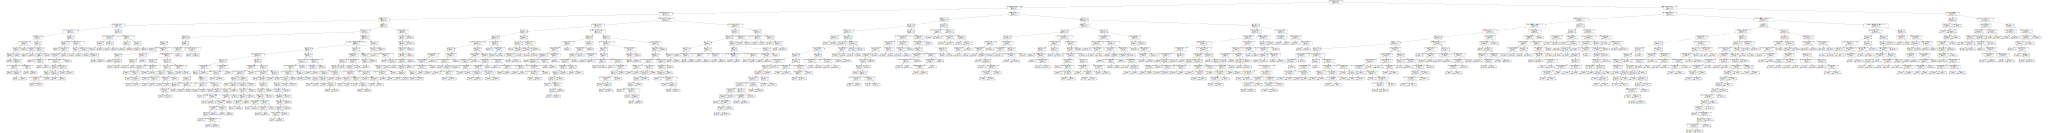

In [89]:
clfplot=export_graphviz(clf2.best_estimator_, out_file='my_tree2.dot', feature_names=features)
with open('my_tree2.dot') as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

# Save the selected estimator

In [92]:
# Save the trained model
joblib.dump(clf2, os.path.join('model', 'trained_model.pkl'))

['model/trained_model.pkl']

In [93]:
# Save the test data to a csv file
df_ = pd.DataFrame(data=X_valid, index=bldgs_valid, columns=features)
df_.to_csv(os.path.join('model', 'test_data.csv'), encoding='utf-8', index_label='buildings')

In [94]:
# These are the predictions on the data from the trained model...
p = pd.DataFrame(data=clf2.predict(X_valid), index=bldgs_valid, columns=['Predicted Monthly Water Consumption'])
p = pd.concat([p, df_], axis=1)
p.to_csv(os.path.join('model', 'predictions_test.csv'), encoding='utf-8', index_label='buildings')
